<a href="https://colab.research.google.com/github/tizianofucci/A2NDLSegmentation/blob/main/Notebook/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

In [3]:
cwd = os.getcwd()

In [4]:
labels_dict  = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}


# Example: Image Segmentation
## Build segmentation

In [5]:
import shutil
import random
import json
import math

SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.path.join(os.path.dirname(os.getcwd()),"VQA_Dataset")

#Save all possible path in order to be able to cycle over them
dataset_image_dir = os.path.join(cwd,'Images')

dataset_QA = os.path.join(cwd,'train_questions_annotations.json')

test_QA = os.path.join(cwd,'test_questions.json')


In [6]:
print(dataset_QA)
print(test_QA)

C:\Users\ASUS\Documents\Università\ANNDL\A2NDLVisualQuestionAnswering\VQA_Dataset\train_questions_annotations.json
C:\Users\ASUS\Documents\Università\ANNDL\A2NDLVisualQuestionAnswering\VQA_Dataset\test_questions.json


In [7]:
with open(dataset_QA) as f:
    q_dict = json.load(f)

In [8]:
for key in q_dict:
#     q_dict[key]['answer'] = labels_dict[q_dict[key]['answer']]
    print(q_dict[key]['answer'])

man
blanket
bench
yes
man
no
yes
brown
no
no
yes
no
no
1
gray
yes
yes
no
yes
no
soccer
yes
no
3
playing
sitting
food
no
2
man
yes
no
orange
no
1
yes
blanket
2
1
no
red
yellow
no
no
2
no
blue
red
2
2
baseball
yes
yes
nothing
dog
no
yes
no
no
yes
tree
2
stool
yes
no
yes
yes
no
1
yes
yes
2
yes
2
brown
yes
red
yes
yes
red
1
no
yes
1
0
no
red
no
3
2
no
yes
no
yes
woman
log
yes
no
tree
bike
yes
sitting
yellow
no
yes
2
3
no
no
floor
stool
yes
yes
2
yes
yes
yes
yes
red
no
no
no
no
1
no
yes
yes
yes
no
red
yes
yes
no
4
yes
yes
2
nothing
table
1
orange
no
no
standing
red
2
yes
4
no
yes
no
yellow
no
no
yes
no
2
brown
yes
2
blue
2
yes
sleeping
no
plant
apple
black
yes
no
no
yes
no
no
blue
yes
squirrel
3
4
soccer
no
orange
yes
yes
yes
no
grass
yes
left
yes
no
yes
bone
no
yellow
orange
no
no
red
girl
2
no
red
yes
2
white
log
yes
white
yellow
2
no
yes
yes
1
5
table
2
no
wine
yes
yes
blue
no
1
2
1
yes
4
table
red
1
yes
yes
2
no
nothing
no
couch
no
2
1
yes
yes
yes
yes
blue
3
5
5
0
brown
red
sandbox
yes


no
football
0
yes
no
no
cat
woman
yes
sleeping
brown
sitting
no
2
bone
no
yes
tree
red
3
cat
couch
no
2
no
yes
yes
no
yes
yellow
no
yes
no
gray
3
1
yes
boy
2
table
yes
2
no
yes
no
yes
yes
4
3
yellow
no
no
orange
yes
yes
no
white
no
book
3
floor
2
4
0
yes
yes
1
yes
yes
yes
no
orange
1
no
yes
yes
yes
no
1
yes
yes
yes
yes
no
1
soccer
yes
yes
blue
2
yes
yes
no
yes
yes
3
2
yes
yes
yes
1
white
no
yes
no
sleeping
yes
1
sitting
yes
yes
yes
yes
yes
yellow
yes
blue
2
dog
plant
1
woman
yes
soccer
yes
no
boy
yes
2
yes
blue
bench
yes
book
book
yes
yes
yes
woman
no
playing
yes
yes
yes
yes
2
2
3
blue
yes
yes
yes
yes
monkey bars
no
baseball
yes
plant
yes
table
yes
yes
yes
green
yes
no
2
2
blue
bike
orange
wine
3
cat
yes
blue
yes
2
4
tree
yes
2
yes
table
yes
no
yes
yes
2
red
1
no
red
yes
white
yes
yes
no
yes
yes
yes
yes
woman
no
yes
red
no
1
yes
1
bench
yes
3
white
yes
red
2
3
4
standing
no
yes
yes
no
yes
yes
grass
2
0
yes
yes
yes
yes
2
yellow
red
1
1
yes
no
1
red
no
yes
yellow
white
woman
yes
yes
2
ye

no
rug
no
no
log
yes
no
sitting
blue
yes
yes
red
no
yes
pie
playing
yes
no
monkey bars
yes
standing
yes
yes
food
yes
yes
yes
2
yes
yes
no
no
yes
red
2
no
no
yes
red
no
yes
red
yes
yes
2
left
black
yes
soccer
yes
yes
yes
yes
yes
yes
yes
yes
red
brown
no
red
0
yes
no
bird
2
yes
yes
no
3
no
no
2
no
yes
blue
yes
no
yes
yes
2
1
1
no
rug
yes
brown
no
5
1
soccer
yes
1
3
dog
no
4
orange
no
2
4
red
yes
log
2
yes
nothing
blanket
no
yes
yes
yes
white
3
yes
red
yes
yes
1
yes
red
2
rug
cat
woman
no
soccer
yes
brown
yes
yes
plant
yes
3
brown
no
4
red
1
yes
yes
table
bench
2
yes
monkey bars
0
yes
yes
no
no
yes
dog
white
yes
yes
yes
log
yes
pie
blue
right
no
yes
2
yes
table
brown
yes
yes
no
2
4
2
no
yes
no
monkey bars
yes
yes
brown
bone
playing
no
1
yes
dog
dog
yes
2
4
cat
no
1
yes
stool
3
no
white
brown
no
yes
no
no
brown
yes
3
yes
0
no
yes
wine
yellow
1
black
bird
brown
yes
soccer
no
no
yes
no
yes
4
man
yes
no
yes
1
tree
yes
yes
no
yes
tree
2
yes
brown
red
yes
yellow
red
green
white
no
yes
watermelo

no
1
yes
1
rug
2
yes
no
sitting
4
no
1
yes
dog
red
no
2
yes
yes
yes
3
floor
2
watermelon
black
yes
yes
red
no
no
1
white
yes
sunny
3
2
blue
yes
yes
no
no
yes
soccer
2
football
2
yes
yes
red
no
yes
no
yes
yes
yes
sleeping
boy
yes
no
red
0
no
soccer
left
blue
football
2
sandbox
no
5
3
no
2
brown
plant
no
0
yes
yes
blue
yes
yes
no
yes
yes
yes
2
playing
2
man
yes
yes
nothing
yes
no
2
woman
floor
2
food
yes
3
yes
no
yes
white
no
yes
yes
yes
boy
no
red
gray
yes
no
yes
rug
1
1
3
no
2
yes
gray
yes
yes
table
yes
yellow
no
yes
yes
yes
yes
baseball
sunny
no
1
yes
no
3
yes
no
no
sandbox
log
no
4
yes
yes
no
yes
baseball
boy
baseball
yes
yes
yes
no
4
3
1
2
yellow
dog
yes
1
football
2
yes
yes
right
sandbox
yes
yes
2
red
brown
yes
yes
yes
2
baseball
tree
pie
3
no
no
blue
no
1
yes
yes
yes
4
green
3
yes
yes
yes
yes
no
no
yes
yes
yes
no
blue
yes
red
yes
no
yes
apple
yes
2
yes
yes
yes
yes
yes
monkey bars
red
no
no
yes
no
dog
yes
no
no
no
no
yes
2
4
2
sitting
2
yes
yes
yes
2
red
1
no
yes
no
yes
no
yes
yes


grass
1
no
no
yes
yes
no
black
1
brown
yes
floor
no
yes
yes
no
yes
0
no
yes
yes
food
no
floor
sleeping
2
no
yes
baseball
yes
5
3
yes
no
football
yes
sunny
plant
1
no
yes
standing
yes
yes
brown
3
playing
yellow
no
no
yes
yes
0
woman
no
yes
rug
yes
no
3
2
yes
no
1
0
couch
yellow
yes
no
2
0
no
3
no
no
yes
red
no
4
yes
red
yes
yes
no
blanket
yes
2
yes
blue
yes
no
white
1
yes
white
white
yes
yes
no
4
yes
no
no
3
no
no
plant
1
2
yes
rug
2
no
2
no
brown
no
3
dog
yes
no
no
no
no
no
yes
4
yes
yes
yes
2
yes
food
left
no
no
cat
4
no
3
sitting
2
soccer
no
right
2
no
yes
yes
red
no
3
2
yes
yes
dog
yes
2
yes
yes
yes
yes
red
sandbox
yes
yes
yes
red
yes
no
yes
yes
no
2
2
no
no
girl
3
no
3
2
white
yes
no
food
no
5
0
blue
2
no
floor
green
grass
yes
yes
1
yes
no
no
no
1
yes
no
no
no
yellow
2
no
bike
black
tree
1
no
no
no
monkey bars
3
no
bike
yes
brown
brown
red
yes
couch
yes
red
yes
yes
white
no
sandbox
4
yes
table
yes
2
book
red
yes
boy
grass
2
bone
no
watermelon
2
2
plant
dog
no
black
yes
yes
2
rug
ye

2
yes
no
sleeping
2
2
red
sitting
yes
2
no
yes
2
yes
yes
black
no
no
yes
2
no
yes
yes
no
no
dog
yes
yes
no
1
no
yes
rug
no
no
yes
no
green
no
no
no
3
yes
3
yes
yes
no
no
0
red
2
yes
2
dog
no
woman
yes
rug
2
yes
yes
no
no
yes
yes
yes
yes
no
4
no
yes
2
1
2
yes
yes
bike
left
0
yes
yes
right
2
table
no
yes
bike
2
3
woman
squirrel
yes
yes
2
standing
red
white
sunny
soccer
yes
5
apple
yes
yes
no
yes
2
no
sitting
dog
no
yes
yes
yes
red
5
sunny
yes
yes
no
yellow
baseball
no
playing
no
yes
yes
2
0
plant
yes
soccer
sitting
yes
red
yes
red
brown
green
girl
yes
2
man
yes
yes
yes
yes
no
1
no
red
yes
red
3
yes
1
3
sitting
no
plant
no
yes
2
2
1
no
brown
man
yes
yes
yes
sitting
yes
yes
2
no
bench
yes
dog
no
red
2
2
yes
no
yes
no
2
2
yes
no
nothing
yes
couch
yes
yes
book
2
yes
no
yes
bone
gray
no
3
sleeping
black
1
1
no
yes
no
baseball
baseball
yes
no
left
black
yes
food
no
1
yes
yes
black
yes
woman
yes
yellow
man
green
brown
yes
yes
2
yes
no
red
2
no
yes
brown
2
monkey bars
yes
couch
dog
no
2
0
no
yes

no
red
yes
dog
no
2
no
yes
yes
yes
yes
no
no
yes
no
yes
blue
no
no
left
2
green
3
no
0
2
no
4
wine
log
no
yes
yes
sandbox
soccer
yes
yes
no
yes
3
yes
yes
no
no
yes
yes
red
no
no
red
yes
brown
yes
white
2
nothing
no
yes
yes
soccer
yes
2
yes
yes
no
soccer
yes
brown
no
yes
3
white
sitting
gray
yes
cat
dog
floor
1
yes
1
no
yes
squirrel
yes
couch
1
yes
yes
red
no
football
0
no
yes
no
brown
dog
rug
1
yes
dog
blue
sandbox
yellow
1
yes
2
1
red
green
right
2
watermelon
2
no
no
no
no
wine
yes
yes
no
yes
yes
no
yes
red
no
girl
1
no
left
no
yes
yes
left
yes
woman
gray
white
no
yes
football
no
2
white
1
wine
white
no
yes
no
white
2
sitting
yes
yes
yes
no
2
4
woman
no
yes
yes
yes
no
no
no
2
no
yes
2
no
playing
yes
yes
yes
yes
orange
yes
no
blanket
yes
yes
yes
red
yes
2
1
no
2
table
no
no
no
no
yes
no
1
yes
soccer
0
2
yes
no
playing
floor
yes
2
1
yes
bike
yes
no
yes
yes
boy
red
football
right
pie
no
yes
playing
black
playing
no
cat
no
bike
orange
yes
no
no
2
0
yes
2
0
yes
no
red
5
4
no
yes
rug
yes
ye

yes
wine
5
yes
no
rug
yes
yes
no
blue
apple
1
blue
sitting
no
yes
1
apple
0
table
no
yes
dog
standing
yes
bike
yes
yes
2
yes
yes
cat
2
yes
couch
yes
yes
yes
no
2
yes
book
yes
no
yes
no
black
floor
no
left
2
no
no
1
white
yes
yes
yes
2
bike
no
yes
yes
yes
1
yes
man
2
2
yellow
yes
no
yellow
yes
yes
4
1
no
cat
yes
no
yes
yes
yes
no
green
no
no
yes
yes
yes
2
yes
no
yes
brown
yes
yes
pie
2
yes
yes
no
sleeping
man
no
yes
1
bone
chair
yes
sleeping
no
blue
yes
2
bike
no
yes
man
yes
yes
no
yes
yes
yes
no
yes
white
1
yes
yes
table
no
yes
no
sitting
2
green
sandbox
yes
2
yes
yes
yes
no
no
yes
yes
white
3
red
yes
no
blanket
yellow
yes
yes
no
2
no
no
no
no
yellow
2
no
yes
yes
yes
yes
no
red
yes
no
soccer
log
yes
yes
yes
2
no
2
dog
bike
yes
yes
floor
yes
white
no
no
blanket
bike
yes
4
white
right
brown
no
yes
yes
1
no
no
no
yes
yes
1
no
no
3
yes
2
2
blue
yes
no
2
yes
sleeping
yes
yes
no
no
yes
red
no
1
yes
yes
no
yes
no
yes
yes
yes
yes
3
yes
yes
yes
no
yes
no
2
pie
yes
2
no
yes
yes
no
no
no
yes
yell

yes
yes
yes
no
yes
no
sitting
black
gray
bird
cat
no
brown
2
red
1
yes
yes
yes
yes
no
no
yes
2
yes
no
no
yes
no
yellow
no
sleeping
yes
yes
no
no
yes
no
dog
white
yellow
2
yes
no
yes
bird
bench
dog
1
green
no
boy
1
0
1
brown
no
girl
yes
playing
yes
red
0
no
3
yes
yellow
yes
no
yes
no
no
yes
yes
white
3
yes
yes
2
white
no
watermelon
2
yes
no
2
woman
squirrel
monkey bars
no
blue
1
no
green
yes
0
yes
4
no
yes
no
yes
plant
2
sitting
rug
no
yes
white
yes
black
no
1
1
0
sleeping
plant
yes
dog
girl
yes
brown
2
yes
no
2
no
yes
yes
couch
no
yes
yes
nothing
standing
yes
yes
yes
yes
2
no
sleeping
apple
sunny
no
no
plant
bench
3
yes
yes
yes
2
yes
yes
1
no
yes
no
yes
wine
yes
3
no
yes
no
wine
no
3
3
4
nothing
1
no
cat
2
yes
no
floor
3
sandbox
yellow
no
no
no
yes
2
1
2
no
yes
sandbox
yes
red
yes
yellow
no
yes
watermelon
2
1
no
yes
yes
yes
no
yes
black
yes
grass
2
2
yes
yes
no
no
yes
sitting
no
soccer
yes
yes
4
no
no
soccer
dog
yes
yes
no
blue
1
log
nothing
soccer
yes
yes
tree
yes
yes
3
playing
no
bik

5
no
2
yes
wine
2
yes
no
yes
yes
no
yes
1
yes
white
1
green
2
red
yes
football
no
yes
food
yellow
no
table
2
1
no
2
no
couch
yes
2
rug
standing
floor
yes
no
yes
yes
2
red
yes
4
yes
gray
no
sitting
3
yes
tree
0
yes
white
no
yes
blue
3
1
no
yes
no
yes
blue
no
no
3
no
yes
yes
yes
yes
yes
no
3
no
yes
yes
yes
yes
0
yes
yes
no
yes
yes
yes
yes
yes
2
no
yes
girl
no
1
yes
no
no
plant
no
plant
no
yes
2
yes
no
couch
yes
yes
red
yes
yes
plant
watermelon
yes
dog
no
no
table
brown
yes
white
right
red
5
yes
yes
no
no
wine
dog
blue
yes
yes
2
yes
yellow
bone
plant
1
yes
yes
2
yes
cat
yes
yes
yes
food
sitting
red
floor
no
5
standing
no
no
white
no
yes
sleeping
sandbox
yes
no
yes
yes
yes
bench
blanket
yes
log
wine
2
yes
yes
4
2
no
no
yes
2
left
2
right
bird
yes
no
no
yes
no
right
no
yes
yes
yes
no
orange
yellow
white
3
yes
no
white
no
no
no
yes
no
red
food
yes
no
3
3
no
yes
yes
yes
food
orange
yes
no
3
watermelon
yes
wine
bird
left
no
yes
yes
dog
no
bench
yes
yes
yes
blue
no
no
3
white
no
2
white
3
no
wh

yes
4
sitting
yes
yes
no
white
sandbox
boy
yes
red
floor
yes
no
yes
no
yes
yes
no
playing
no
2
dog
yes
no
no
no
monkey bars
yes
yes
red
2
rug
red
yellow
no
2
sleeping
1
2
red
yes
yes
no
no
no
no
blue
right
yes
2
yes
no
yes
yes
no
apple
yes
no
brown
dog
yes
red
playing
1
no
no
yes
blue
4
5
log
no
yes
green
white
white
yes
no
yes
2
man
no
1
2
4
grass
stool
yes
yes
blanket
no
yes
no
no
yes
black
yes
sandbox
black
3
yes
apple
sandbox
no
yes
yes
monkey bars
soccer
yes
red
apple
yes
yes
yes
yes
no
no
no
no
3
book
yes
red
no
yes
yes
3
couch
2
no
brown
no
1
plant
2
no
yes
yes
no
squirrel
red
yes
yellow
no
dog
yes
rug
couch
2
man
no
no
1
sitting
sleeping
nothing
gray
yes
no
no
yes
yes
table
yes
no
yes
yes
no
no
no
yes
yes
orange
left
no
monkey bars
yes
brown
no
dog
bench
dog
2
2
3
yes
4
1
red
yes
0
no
2
no
2
2
no
2
yes
playing
4
2
yes
gray
yes
dog
book
yes
yes
yes
2
grass
no
red
2
bone
3
1
yes
yes
yes
yes
yes
yes
yes
1
yes
red
no
yes
2
2
2
no
yellow
sandbox
yes
yes
table
1
1
yes
red
yellow
yes


5
yes
5
yes
no
yes
pie
cat
1
1
no
yes
yes
right
yes
brown
no
yes
bench
yes
floor
cat
apple
4
white
yes
red
1
blue
yes
table
cat
no
cat
orange
orange
chair
book
no
2
white
no
dog
no
no
no
no
yes
2
yes
3
no
yes
1
0
dog
bench
yes
2
yes
yes
yes
1
2
no
dog
plant
no
yes
no
woman
monkey bars
no
4
sitting
4
no
no
no
bone
yes
yes
3
2
2
white
no
no
yes
white
yes
yes
yes
no
yes
no
yes
white
2
yes
right
1
no
no
black
right
no
no
yes
3
wine
yes
red
playing
yellow
no
woman
no
watermelon
woman
yes
2
yes
1
red
soccer
yes
blue
boy
sleeping
green
1
no
white
yes
no
2
yes
yes
no
red
3
yes
yes
yes
man
dog
1
yes
no
2
5
2
yes
no
red
yes
3
tree
white
2
yes
yes
no
1
no
yes
yes
yes
yes
woman
yes
yes
no
tree
no
4
0
man
no
2
yes
no
left
1
1
sitting
wine
yes
yes
no
sitting
yes
yes
tree
no
yes
yes
blue
yes
no
watermelon
yes
2
brown
no
4
yes
2
no
yes
no
yes
yes
no
sandbox
2
yes
yes
no
no
sunny
0
yes
yellow
1
no
brown
yes
yes
log
yes
yes
yes
blue
yes
no
2
yes
2
3
yes
yes
red
green
yes
no
no
2
yes
yes
yes
yes
no
no
do

baseball
yes
no
right
no
yes
yes
yes
1
yes
yes
orange
squirrel
2
yes
white
no
no
yes
yes
right
yes
white
2
2
cat
woman
2
4
gray
gray
no
girl
yes
yes
no
red
yes
yes
3
yes
yes
yes
yes
no
yes
yes
food
yes
yellow
2
yellow
yes
yes
no
dog
book
no
yes
yes
yes
3
no
no
yes
2
monkey bars
yes
no
no
yes
girl
yes
no
1
1
yes
yes
red
white
white
no
2
yes
yes
no
yes
black
blanket
no
yes
2
yes
2
green
yes
left
yes
yes
0
yes
2
no
white
yes
squirrel
sunny
yes
grass
watermelon
yes
yes
yes
brown
yes
sitting
black
sitting
boy
bird
yes
white
yes
yes
white
no
yes
2
red
yes
wine
yes
no
yes
yes
red
no
yes
no
sandbox
1
no
yes
yellow
dog
no
no
cat
yes
red
no
yes
2
2
woman
no
yes
yes
no
cat
gray
no
yes
no
yes
no
yes
1
yes
yes
yes
no
no
4
black
yes
table
red
red
yes
baseball
red
dog
yes
yes
3
yes
yes
no
no
2
yes
1
no
4
no
2
yes
no
yes
2
yes
no
2
brown
no
yes
cat
3
yes
no
table
tree
yes
1
no
yes
3
sunny
2
2
plant
yes
no
man
blue
yes
yes
no
yes
yes
yes
no
2
yes
3
woman
bird
no
yes
1
no
yes
5
football
4
football
yes
1

yes
sunny
no
man
2
nothing
pie
yes
no
no
no
yes
no
no
yes
no
bird
grass
yes
yes
no
no
yes
2
yes
yes
2
yes
green
right
no
yes
3
5
food
4
couch
3
no
no
yes
1
2
yes
soccer
yes
2
yes
yes
1
yes
no
yes
no
white
2
yes
2
no
1
3
4
yes
no
4
grass
blanket
nothing
yes
black
no
no
no
white
soccer
1
1
0
yes
yes
table
pie
sitting
sleeping
yes
dog
no
yes
yes
yes
wine
yes
yes
yes
white
soccer
boy
standing
yes
2
no
no
no
no
plant
2
yes
no
yes
yes
green
yes
yes
yes
sitting
red
3
pie
no
2
no
3
yes
brown
yes
brown
no
yes
5
yellow
bone
no
no
yes
yes
yes
3
stool
yes
brown
sitting
yes
1
yes
yes
yes
red
5
yes
no
2
no
yes
girl
dog
0
yes
yes
no
couch
yes
2
yes
watermelon
yes
red
man
yes
no
yes
left
yes
yes
2
watermelon
no
no
yellow
yes
book
yes
yes
yes
yes
no
blue
yes
no
gray
white
rug
2
grass
no
yes
4
log
no
no
no
no
green
1
3
yes
no
no
no
bike
no
no
1
yes
1
no
yes
bike
yes
no
apple
yes
2
no
no
3
2
yes
pie
watermelon
blanket
yes
yes
table
4
yes
3
yes
3
yes
no
yes
soccer
yes
yellow
orange
yes
1
blanket
yes
no
no

no
yes
yes
yes
green
yes
no
5
yes
no
2
no
red
yes
playing
yes
sandbox
yes
yes
no
2
no
no
yes
no
2
right
yes
2
no
table
no
white
no
no
no
blue
yes
sitting
1
sitting
no
white
dog
sandbox
yes
yes
4
white
1
black
2
yes
log
no
yes
blue
sunny
yes
squirrel
no
log
yes
no
1
yes
no
yes
no
4
red
log
yes
yes
log
white
yes
white
3
stool
brown
3
no
yes
no
yes
3
no
white
orange
yes
playing
playing
2
yes
4
red
floor
cat
yes
playing
yes
watermelon
watermelon
yes
yes
no
yes
no
yes
yes
1
4
no
blue
floor
yes
yes
yes
no
3
woman
blue
yes
bike
sunny
yes
white
1
football
red
watermelon
floor
2
yes
food
white
no
2
white
no
no
dog
no
yes
yes
yes
yes
no
2
2
yes
yes
red
red
no
left
no
no
2
yes
yes
yes
pie
yes
no
yes
yes
no
yes
yes
no
no
yes
yellow
2
brown
no
yes
no
white
yes
green
sitting
2
no
chair
no
yes
tree
3
3
yellow
yes
book
dog
no
no
no
dog
3
yes
man
no
1
right
yes
football
yes
football
no
3
yes
yes
yes
white
yellow
red
yes
red
blue
no
no
playing
standing
3
yes
yes
no
yes
yes
3
yes
no
yes
5
no
yes
1
yes
3


no
red
yes
red
yes
red
no
yes
no
yes
no
no
yes
no
sitting
no
no
yes
0
black
no
yes
1
2
sitting
no
yes
3
no
no
brown
no
no
yes
no
no
white
cat
red
3
pie
yes
1
no
no
no
yes
couch
yes
2
cat
1
2
no
yes
yes
yes
2
no
right
yes
girl
no
yes
3
no
no
yes
wine
yes
no
football
yes
yes
yes
yes
0
yes
green
red
2
0
red
yes
bone
no
squirrel
no
4
yes
yes
no
soccer
0
yes
1
no
3
rug
apple
watermelon
cat
red
1
1
yes
watermelon
yes
no
no
yes
no
1
3
no
wine
bike
yes
red
dog
yes
yes
3
1
yes
yes
left
no
no
yes
yes
yes
1
1
gray
brown
yes
0
yes
no
man
red
2
2
yes
1
2
no
blue
yes
table
no
yes
playing
1
yes
red
3
no
yes
0
3
bike
1
yes
no
yes
no
couch
yes
yes
no
yes
chair
yes
3
yellow
2
yes
yes
yes
red
yes
blue
no
no
bird
sleeping
2
no
no
yes
brown
standing
yes
right
no
2
no
yes
brown
1
no
pie
3
yes
cat
red
white
no
cat
brown
no
1
right
yes
yes
2
no
yes
yes
boy
yes
yes
bone
blue
yes
yes
no
playing
yes
yes
2
no
yes
sleeping
stool
2
no
wine
no
yes
1
3
2
left
nothing
no
2
no
yes
2
1
5
no
yes
no
5
3
1
yes
yes
yes
yes


yes
bench
yes
yes
no
cat
2
yes
food
no
no
0
blanket
yes
2
no
yes
blue
yes
yes
2
sleeping
red
yes
0
right
floor
2
wine
no
red
dog
3
yes
2
1
no
sunny
yes
yes
no
yes
football
no
football
playing
yes
yes
yes
yes
nothing
yes
no
2
brown
yes
2
yes
no
green
1
yellow
no
soccer
2
no
red
yes
dog
sandbox
yes
1
3
no
apple
green
wine
playing
yes
yes
dog
yes
no
yes
yes
no
yes
3
yes
dog
cat
grass
yes
yes
no
dog
yes
1
3
no
playing
no
rug
no
yes
blue
blue
wine
no
no
grass
girl
no
no
no
log
yes
yes
yes
left
yes
yes
yes
squirrel
2
yes
log
dog
no
4
yes
yes
no
yes
3
green
2
1
no
orange
no
left
yes
yes
blanket
green
yes
yes
yes
brown
yes
no
no
3
no
yes
red
1
3
no
yes
yes
yes
1
no
table
no
yes
woman
yes
no
2
3
white
yes
yes
yellow
no
yes
yes
red
4
2
2
red
no
2
no
cat
yes
no
white
yes
monkey bars
left
stool
yes
no
pie
yes
yes
yes
no
floor
2
black
1
no
yes
1
no
no
yes
yes
no
black
1
2
yes
yes
yes
no
yes
yes
no
sunny
2
boy
red
yes
red
4
right
2
yes
yes
yes
white
nothing
boy
yes
1
wine
1
yes
2
white
no
white
1
no

yes
playing
yes
yes
yes
watermelon
yes
no
no
yes
yes
no
yes
3
food
no
squirrel
no
white
2
no
no
yes
white
no
dog
yes
yes
2
bench
gray
no
yes
1
2
yes
yes
brown
couch
no
gray
yes
yes
no
plant
blue
blue
2
yes
1
no
white
3
no
no
sitting
yes
yes
sitting
yes
green
yes
no
no
yes
sleeping
2
red
dog
yes
yes
yes
2
1
3
soccer
yes
yes
no
3
no
gray
1
2
blue
no
yes
no
no
yes
no
blue
dog
yes
red
yes
yes
bone
table
yes
rug
1
sitting
yes
yes
yes
1
2
1
football
pie
3
grass
yes
sitting
left
no
food
2
playing
yes
yes
blanket
yes
floor
cat
no
soccer
no
yes
no
yes
red
yes
floor
standing
yes
no
2
woman
black
no
yes
no
sitting
yes
no
no
no
1
yes
yes
girl
no
yes
football
yes
black
3
no
yes
3
yes
yes
sitting
no
no
red
dog
no
no
yellow
black
tree
no
bone
yes
yes
no
yes
yes
no
no
no
2
yes
yes
2
yes
no
blanket
yes
no
3
book
no
red
1
no
no
sunny
red
yes
no
no
no
yes
yes
3
no
no
no
3
yes
yes
sitting
soccer
watermelon
log
no
yes
pie
2
yes
yes
red
yes
yes
bird
3
no
no
tree
boy
yes
yes
brown
no
white
chair
yes
yes
rug


red
4
white
wine
yes
sitting
0
food
1
yes
yellow
1
couch
yes
yes
2
yes
1
yes
no
0
yes
no
2
no
no
2
baseball
yellow
no
yes
no
2
no
1
yes
no
dog
yes
book
no
yes
yes
yes
red
no
yes
yes
yes
yes
1
2
no
2
yes
yes
orange
3
no
wine
no
wine
yes
yes
no
blanket
wine
pie
red
3
apple
yes
boy
sandbox
no
no
yes
yes
no
woman
2
2
yes
yes
orange
yellow
yes
food
white
no
no
cat
yes
yes
chair
yes
no
0
no
blue
yes
right
yes
yes
sandbox
no
yes
no
yes
yes
yes
yes
yes
yes
blue
table
yes
yes
3
no
yes
white
1
no
yes
1
4
no
no
sandbox
no
nothing
yes
no
no
yes
log
yes
no
0
sunny
log
no
no
floor
wine
no
yes
no
yes
no
nothing
bench
no
no
red
no
yes
chair
monkey bars
no
yes
no
2
man
floor
yes
gray
3
blue
wine
4
yes
yes
1
no
1
no
brown
yes
white
dog
4
no
yes
no
1
bike
4
standing
white
yes
no
no
2
0
brown
bird
yes
2
yes
1
yes
yes
blue
2
yes
no
man
yes
no
yes
1
yes
1
no
no
sitting
no
yes
gray
sitting
yes
no
left
apple
yes
yes
no
no
left
standing
cat
red
yes
yes
monkey bars
yes
soccer
yellow
no
no
yes
yes
no
blue
no
2
y

yes
yes
no
yes
yes
yes
yes
no
chair
yes
yes
yes
yes
green
2
girl
green
black
yellow
yes
yes
table
2
left
red
sunny
no
2
no
brown
no
red
sunny
boy
1
no
3
3
2
yes
2
3
2
boy
food
stool
no
cat
yes
yes
no
yes
chair
yes
blue
yes
red
yes
yellow
no
no
sitting
cat
yes
2
bench
yes
yes
no
2
3
black
yes
yes
1
yes
yes
red
2
yes
yes
yes
man
bird
yes
yes
0
0
sunny
yellow
yes
white
no
no
sitting
red
yes
bench
yes
no
yes
cat
yes
yes
yes
dog
1
white
yellow
rug
yes
yes
no
squirrel
no
yes
1
no
yes
yes
white
no
yes
yes
yes
yellow
yes
yes
no
3
yes
yes
2
no
no
yes
yes
yes
no
no
blue
no
log
yes
yes
yes
yes
2
wine
woman
no
blue
blue
grass
yes
yes
yes
sleeping
yes
2
floor
yes
no
soccer
red
yes
yes
no
3
no
2
no
yes
2
1
no
baseball
baseball
cat
book
yellow
nothing
brown
yes
yes
woman
rug
sandbox
yes
cat
yes
yes
yes
man
no
no
blue
yes
yes
no
brown
1
yes
yes
2
2
yellow
red
yes
food
grass
yes
no
3
bird
yes
yes
bird
yes
no
no
red
brown
wine
cat
yes
yes
2
no
yes
green
5
yes
no
yes
no
yes
yes
red
couch
yes
4
no
no
no
w

yes
no
yes
yes
1
yes
yes
1
yes
yes
yes
2
white
2
2
1
red
yes
yes
3
yes
wine
yes
0
white
yes
yes
no
grass
yes
3
0
red
soccer
log
no
1
floor
yes
yes
2
yes
playing
yes
no
2
red
brown
1
yes
yes
no
sleeping
no
yes
no
yes
playing
1
no
soccer
gray
yes
no
brown
yes
chair
1
2
no
boy
yes
no
2
red
log
2
orange
yes
no
2
3
2
white
2
no
couch
no
yes
no
1
1
brown
yes
no
no
1
no
yes
yes
2
no
no
green
log
white
5
1
yes
no
yes
yes
red
chair
no
brown
yes
yes
yes
yes
sunny
yes
yellow
no
no
right
yes
woman
yes
3
blue
yes
yes
2
no
woman
yes
yes
yes
no
4
yes
dog
no
sunny
no
yes
yes
no
no
yes
right
no
no
no
left
no
4
1
5
soccer
yes
blue
couch
no
standing
4
no
2
green
no
yes
no
no
no
2
yes
1
pie
yes
no
yes
yes
3
no
3
book
book
no
3
yes
black
yellow
no
no
4
no
yes
yes
5
gray
2
yes
yes
yes
no
orange
no
no
yellow
bike
bird
gray
no
no
no
2
yes
2
no
no
no
yellow
nothing
cat
yes
3
yellow
yes
red
left
yellow
1
2
no
gray
no
no
no
nothing
no
yes
yes
soccer
log
yes
orange
yes
red
wine
yes
yes
yes
yes
1
stool
no
no
red
n

2
soccer
red
2
no
no
3
no
yes
man
4
yes
yes
green
no
boy
yellow
yes
no
no
no
no
yes
yes
stool
blue
no
yes
white
white
no
1
no
blue
standing
yes
2
yes
yes
green
yes
bird
sandbox
4
bone
orange
bike
0
yes
left
squirrel
no
red
yes
yes
yes
yes
green
no
1
no
4
yes
blue
red
no
1
no
yes
no
cat
yes
sunny
yes
yes
4
white
plant
sitting
couch
no
pie
yes
monkey bars
1
5
orange
yes
no
yes
black
yes
no
no
no
couch
4
sunny
no
no
yes
watermelon
yes
yes
dog
couch
black
yes
1
no
2
yes
black
no
red
yes
yes
no
2
yes
yes
5
white
monkey bars
yes
no
yes
yes
cat
red
yes
2
yes
yes
yes
1
no
no
blue
no
yes
girl
no
2
yes
floor
yes
no
yes
yes
red
couch
yes
red
cat
yes
bench
yes
yes
cat
yes
yes
food
watermelon
2
yes
yes
no
no
no
black
0
black
gray
no
no
yes
wine
yes
tree
food
yes
baseball
no
no
yes
red
yes
3
yes
4
2
yes
yes
no
yes
yellow
playing
yes
1
yes
yes
blue
yes
man
2
black
left
yes
yes
yes
2
dog
food
white
yes
no
2
yes
no
yes
yes
2
yes
yellow
yes
sitting
tree
no
no
apple
yes
yellow
plant
blue
yes
2
2
no
girl


no
no
4
brown
sitting
blue
yes
no
right
yes
no
yes
yes
2
no
3
no
3
no
left
1
4
yes
2
2
3
no
no
blue
monkey bars
yes
no
white
book
yes
yes
yes
yes
sitting
cat
red
yes
yes
red
yes
right
red
bike
yes
yes
bench
no
no
yes
yes
orange
4
yes
yes
grass
brown
no
white
yes
brown
sunny
green
red
no
4
1
1
2
chair
yes
yes
2
log
right
red
bird
1
yes
no
yes
yes
no
yes
couch
blue
no
no
yes
yes
no
man
no
yes
yes
no
white
5
yes
3
yes
yes
yes
yes
dog
yes
food
yes
yes
watermelon
no
no
3
no
no
3
yes
no
blue
blanket
yes
no
no
yes
yes
yes
2
red
gray
yes
no
3
yes
yes
yes
yes
1
no
no
yes
no
no
yes
2
3
no
1
cat
yes
no
couch
yes
yes
sitting
sitting
no
yes
log
yellow
yes
nothing
no
yes
gray
3
sleeping
table
yes
no
yes
3
green
no
dog
no
yes
yes
yes
no
watermelon
1
no
yes
yes
yes
green
nothing
food
2
standing
yes
playing
blue
girl
cat
no
plant
bike
yes
0
red
yes
yes
cat
yes
no
yes
yes
red
cat
right
yes
book
1
yes
sleeping
yes
no
2
pie
2
0
1
no
table
table
no
yes
no
yes
no
red
no
yes
no
bird
no
1
cat
yes
2
yes
no
yes

right
no
gray
no
no
yes
yes
no
no
5
2
yes
no
3
left
yes
yes
yes
brown
1
yes
woman
1
no
no
standing
rug
yes
1
floor
1
brown
yes
red
no
2
yes
yes
no
yes
no
no
2
no
yes
yes
no
dog
no
yes
0
yes
yes
brown
2
yes
no
no
2
man
no
left
right
no
no
yes
no
yes
yes
no
white
yes
no
0
bird
1
1
stool
yes
yellow
yes
1
woman
2
no
no
gray
couch
nothing
no
yes
no
2
yes
monkey bars
yes
yellow
brown
no
yes
left
yes
yes
plant
4
no
no
yes
no
cat
1
yes
yes
man
yes
yes
no
2
yes
girl
white
no
yes
3
yes
yes
yes
yes
nothing
yes
plant
yes
yes
no
2
dog
2
no
standing
cat
no
table
yes
yes
bird
brown
no
red
yellow
0
no
yes
1
2
3
watermelon
yes
yes
no
no
green
yes
chair
brown
2
yes
no
4
soccer
4
yes
standing
no
3
4
no
yes
2
yes
left
yes
2
no
2
yes
food
yes
yes
black
no
girl
yes
no
yes
chair
no
yes
no
brown
2
no
2
yes
football
yes
yes
right
yes
3
yes
yes
yes
no
yes
yes
floor
yes
nothing
no
couch
yes
no
no
cat
yes
no
bird
baseball
no
red
blue
2
yes
apple
no
yes
food
sleeping
yes
gray
yes
yes
yes
yes
yellow
yellow
1
brown


yes
no
yes
dog
2
1
food
yes
white
no
no
no
no
yes
2
yes
yes
apple
yellow
no
baseball
3
yes
no
no
playing
1
no
2
2
rug
no
3
yes
brown
yes
green
red
cat
red
brown
plant
girl
2
yes
yes
yes
yes
yes
no
2
no
rug
2
cat
2
1
yes
wine
1
yes
1
2
no
yes
2
yes
gray
yes
yes
no
no
yes
white
no
red
no
no
apple
yes
0
yes
yes
sunny
no
yes
1
yes
red
white
yellow
yes
3
yes
squirrel
yes
no
no
no
yes
2
no
no
2
yes
yes
sandbox
yes
brown
yes
yes
yes
no
no
no
yes
0
4
yes
4
3
yes
2
yes
2
grass
food
red
yes
yes
no
red
no
no
yes
no
2
soccer
3
yes
yes
yes
dog
yes
yes
yes
dog
yes
3
3
brown
playing
1
brown
yes
2
2
yes
5
1
2
yes
yes
1
no
2
green
2
watermelon
yes
right
bench
yellow
no
4
no
4
no
yes
yes
brown
yes
red
no
yes
red
no
2
1
table
brown
dog
no
3
yes
yes
rug
2
no
floor
floor
yes
yes
no
yes
2
brown
yes
green
soccer
soccer
man
sandbox
yes
2
red
table
red
yes
blanket
no
yes
yes
3
yes
no
yes
yes
yes
3
no
yes
chair
yes
yes
no
black
yes
red
soccer
yes
1
no
food
1
yes
white
no
sleeping
no
no
sitting
yes
no
plant
blue

man
black
yes
dog
yes
yes
yes
1
white
yes
no
no
yes
yes
yes
yes
dog
1
no
yes
1
yes
2
yes
3
5
yes
2
yes
yes
3
no
3
4
no
2
yes
no
5
yes
yes
left
girl
yes
yes
no
2
soccer
yes
gray
yes
yes
2
no
yes
wine
no
2
man
yes
yes
yes
no
no
no
food
yes
yes
0
plant
no
no
1
1
no
wine
no
yes
yes
1
no
no
yes
3
yes
dog
2
yes
no
yes
yes
yes
no
no
blue
wine
3
0
chair
yes
yes
no
no
2
2
red
2
yes
no
cat
wine
2
yes
yes
no
0
yes
yes
yes
2
yes
yes
dog
sitting
0
yes
yes
0
3
4
yes
3
green
tree
green
blue
gray
yes
no
3
no
no
no
no
yes
woman
yes
table
yes
yes
couch
yes
yes
yes
2
yes
blue
3
yes
yes
1
yes
chair
no
cat
no
2
yes
yes
yes
green
yes
3
blue
yes
red
brown
5
no
5
sandbox
1
no
no
yes
yes
3
book
no
no
yes
yes
no
1
no
yes
yes
yes
yes
dog
tree
yes
no
no
4
yes
yes
yellow
yes
2
2
0
yes
1
red
no
yes
red
woman
no
yes
1
red
no
3
sitting
no
grass
no
yes
2
no
3
yes
no
yes
yes
yes
no
no
1
yes
yes
yes
yes
2
yes
1
yes
playing
food
yes
yes
orange
no
yes
man
4
grass
yes
bird
1
yes
book
yes
yes
yes
2
no
1
black
red
left
no
ye

brown
blue
yes
3
2
white
yes
2
no
apple
yes
no
nothing
playing
yes
yes
right
no
no
red
yes
2
yes
yes
yes
no
nothing
yes
yes
yes
table
wine
no
no
yes
no
yes
gray
yes
yes
yes
no
2
yes
yes
red
orange
yes
yes
yes
yes
no
yes
yes
yes
3
yes
black
3
1
cat
yes
no
table
no
yes
no
yes
yes
white
yes
2
table
yes
green
yes
yes
no
black
yes
yes
yes
gray
right
red
yes
no
yes
apple
yes
2
yes
black
no
4
yes
1
apple
4
no
no
no
cat
yes
floor
yes
yes
no
grass
yes
4
yes
1
no
no
plant
2
yes
playing
yes
white
cat
yes
sitting
sitting
yes
yes
no
yes
woman
red
yes
yes
squirrel
no
yes
yes
white
yellow
yes
no
wine
4
sunny
black
floor
man
red
yes
2
blue
5
yes
yes
yes
yes
yes
yes
no
2
yes
red
red
yes
yes
no
yellow
1
1
1
food
yes
0
table
no
yes
no
floor
yes
2
yes
no
plant
yes
bike
1
yes
yes
yes
yes
standing
0
yes
3
yes
left
couch
yes
no
4
apple
0
blanket
no
1
3
1
grass
no
brown
yes
no
no
yes
yes
1
yes
brown
no
no
yes
no
yes
1
yes
monkey bars
yes
yes
table
1
2
cat
plant
yes
yes
no
no
brown
brown
yes
no
standing
4
yes


In [9]:
# Prepare dataset
# ---------------




MAX_NUM_SENTENCES = 70000
MAX_NUM_WORDS = 20000

answers = []
questions = []
eng_sentences_train = []

# Simplify the dataset
MAX_LEN = 25 # words

# Read all lines in translation dataset
count = 0

for key in q_dict:


#for line in open(os.path.join('/content/drive/My Drive', 'ita.txt'), encoding='utf-8'):
    
    if count > MAX_NUM_SENTENCES:
        break

        
    answer = q_dict[key]['answer']
    question = q_dict[key]['question']

    
    if (len(answer.split(' ')) > MAX_LEN or
          len(question.split(' ')) > MAX_LEN):
      continue
    
    question = question + ' <eos>'
       
    questions.append(question)
    
    answer_arr = np.zeros(58)
    answer_arr[labels_dict[q_dict[key]['answer']]] = 1
    
    q_dict[key]['answer'] = answer_arr
    answers.append(answer)
    
    count += 1

print('Number of questions:', len(questions))

Number of questions: 58832


In [10]:
max(len(sentence.split(' ')) for sentence in questions)

23

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create Tokenizer to convert words to integers
ita_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS)
ita_tokenizer.fit_on_texts(questions)
ita_tokenized = ita_tokenizer.texts_to_sequences(questions)

ita_wtoi = ita_tokenizer.word_index
print('Total Questions words:', len(ita_wtoi))

max_ita_length = max(len(sentence) for sentence in ita_tokenized)
print('Max question length:', max_ita_length)

Total Questions words: 4641
Max question length: 22


In [12]:
# Pad to max italian sentence length
ita_encoder_inputs = pad_sequences(ita_tokenized, maxlen=max_ita_length)

print("Italian encoder inputs shape:", ita_encoder_inputs.shape)


Italian encoder inputs shape: (58832, 22)


In [13]:
count = 0
for key in q_dict:
    q_dict[key]['question'] = ita_encoder_inputs[count]
    count+=1
 

In [14]:
# Build Encoder-Decoder Model
# ---------------------------

EMBEDDING_SIZE = 32

# ENCODER
# -------

encoder_input = tf.keras.Input(shape=[max_ita_length])
encoder_embedding_layer = tf.keras.layers.Embedding(len(ita_wtoi)+1, EMBEDDING_SIZE, input_length=max_ita_length, mask_zero=True)
encoder_embedding_out = encoder_embedding_layer(encoder_input)
encoder = tf.keras.layers.LSTM(units=512, return_state=True)

encoder_output, h, c = encoder(encoder_embedding_out)
encoder_states = [h, c]



# MODEL
model_lstm = tf.keras.Model(encoder_input,encoder_output)

In [15]:
model_lstm.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 32)            148544    
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1116160   
Total params: 1,264,704
Trainable params: 1,264,704
Non-trainable params: 0
_________________________________________________________________


In [16]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
else :
    img_data_gen = ImageDataGenerator()


In [17]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

    """
        CustomDataset inheriting from tf.keras.utils.Sequence.

        3 main methods:
          - __init__: save dataset params like directory, filenames..
          - __len__: return the total number of samples in the dataset
          - __getitem__: return a sample from the dataset

        Note: 
          - the custom dataset return a single sample from the dataset. Then, we use 
            a tf.data.Dataset object to group samples into batches.
          - in this case we have a different structure of the dataset in memory. 
            We have all the images in the same folder and the training and validation splits
            are defined in text files.

      """

    def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
                preprocessing_function=None, out_shape=[256, 256]):
        if which_subset == 'training':
            subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
        elif which_subset == 'validation':
            subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
        with open(subset_file, 'r') as f:
            lines = f.readlines()
    
        subset_filenames = []
        for line in lines:
            subset_filenames.append(line.strip()) 

        self.which_subset = which_subset
        self.dataset_dir = dataset_dir
        self.subset_filenames = subset_filenames
        self.img_generator = img_generator
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self):
        return len(self.subset_filenames)

    def __getitem__(self, index):
        
        
        
        
        # Read Image
        curr_filename = self.subset_filenames[index]
        element = q_dict[curr_filename]
        image = element['image_id']
        img = Image.open(os.path.join(self.dataset_dir, 'Images', image + '.png'))
        #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

        img = img.convert('RGB')
        
        # Resize image and mask
        img = img.resize(self.out_shape)
        

        
       # mask = mask.resize(self.out_shape)
    
        img_arr = np.array(img)
        
        
        
        question = element['question']
        answer = element['answer']
        #print(mask_arr.shape)
  
#         if self.which_subset == 'training':
#             if self.img_generator is not None and self.mask_generator is not None:
                # Perform data augmentation
                # We can get a random transformation from the ImageDataGenerator using get_random_transform
                # and we can apply it to the image using apply_transform
                
#                 img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
#                 mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
#                 img_arr = self.img_generator.apply_transform(img_arr, img_t)
                
                # ImageDataGenerator use bilinear interpolation for augmenting the images.
                # Thus, when applied to the masks it will output 'interpolated classes', which
                # is an unwanted behaviour. As a trick, we can transform each class mask 
                # separately and then we can cast to integer values (as in the binary segmentation notebook).
                # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
#                 out_mask = np.zeros_like(mask_arr)
#                 for c in np.unique(mask_arr):
#                     if c > 0:
#                         curr_class_arr = np.float32(mask_arr == c)
#                         curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
#                         # from [0, 1] to {0, 1}
#                         curr_class_arr = np.uint8(curr_class_arr)
#                         # recover original class
#                         curr_class_arr = curr_class_arr * c 
#                         out_mask += curr_class_arr
#         else:
    
        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)
        
        pair = {"vgg16_input": img_arr, "zzz_input": question}
        
        return pair, answer

In [18]:
if not os.path.exists(os.path.join(cwd,"Splits/")):
    os.makedirs(os.path.join(cwd,"Splits/"))



import json



# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}

val=[]
train=[]

for key in q_dict:
# image_filenames = next(os.walk(os.path.join(dataset_dir[j],"Images/")))[2]



# for image_name in image_filenames:
    if 100*random.random() < 10:
        val.append(key)
    else:
        train.append(key)

with open(os.path.join(cwd,"Splits","train.txt"), 'w') as file:  # Use file to refer to the file object
    for i in train:
        a = file.write(str(i)+"\n")

with open(os.path.join(cwd,"Splits","val.txt"), 'w') as file:  # Use file to refer to the file object
    for i in val:
        a = file.write(str(i)+"\n")



In [19]:
#Creation of dataset generators (the commented line are the ones for getting also the haricot Dataset)

from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 400
img_w = 700

dataset = CustomDataset(cwd, 'training', 
                        img_generator=img_data_gen, preprocessing_function=preprocess_input, out_shape=[img_w,img_h])

dataset_valid = CustomDataset(cwd, 'validation',
                              preprocessing_function=preprocess_input,out_shape=[img_w,img_h])



In [20]:
#Creation of datasets (the commented line are the ones for getting also the haricot Dataset)


train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=({"vgg16_input": tf.float32, "zzz_input": tf.float32}, tf.float32),
                                               output_shapes=({"vgg16_input": [img_h, img_w, 3], "zzz_input":  22}, 58)
                                              )

bs=18


train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=({"vgg16_input": tf.float32, "zzz_input": tf.float32}, tf.float32),
                                               output_shapes=({"vgg16_input": [img_h, img_w, 3], "zzz_input":  22}, 58)
                                              )

valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [21]:
# Let's test data generator
# -------------------------

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline


# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0 0 0 ... 16 21 1]
[0 0 0 ... 0 0 0]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

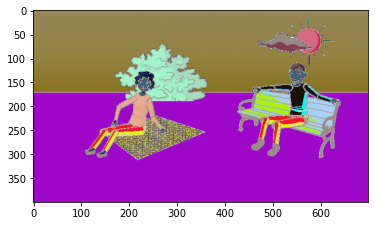

In [22]:

augmented_img = next(iterator)


image = augmented_img[0]['vgg16_input'][0]   # First element

tf.print (augmented_img[0]['zzz_input'][0])
tf.print (augmented_img[1][0])

plt.imshow(np.uint8(image))
plt.plot

In [23]:
#Loading of VGG that will be used as a Backbone
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

# for layer in vgg.layers:
#   layer.trainable = False
freeze_until = 17 # layer from which we want to fine-tune

for layer in vgg.layers[:freeze_until]:
    layer.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 700, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 700, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 700, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 350, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 350, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 350, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 175, 128)     0     

In [24]:
# This function is used for creating a model without skip connections
def create_model():

    model = tf.keras.Sequential()
    model2 = tf.keras.Sequential()
    # Encoder
    # -------
    model.add(vgg)
    model2.add(model_lstm)
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    
    scores = tf.keras.layers.Multiply()([model.output, model2.output])
    
    denso = tf.keras.layers.Dense(units=256, activation='selu')(scores)

    drop = tf.keras.layers.Dropout(0.5)(denso)
    
    output = tf.keras.layers.Dense(units=58, activation='softmax')(drop)
    
    final_model = tf.keras.Model([model.inputs,model2.inputs], output)


    return final_model

In [25]:
model = create_model()

In [26]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vgg16_input (InputLayer)        [(None, 400, 700, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 12, 21, 512)  14714688    vgg16_input[0][0]                
__________________________________________________________________________________________________
functional_1_input (InputLayer) [(None, 22)]         0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 512)          0           vgg16[0][0]                      
_______________________________________________________________________________________

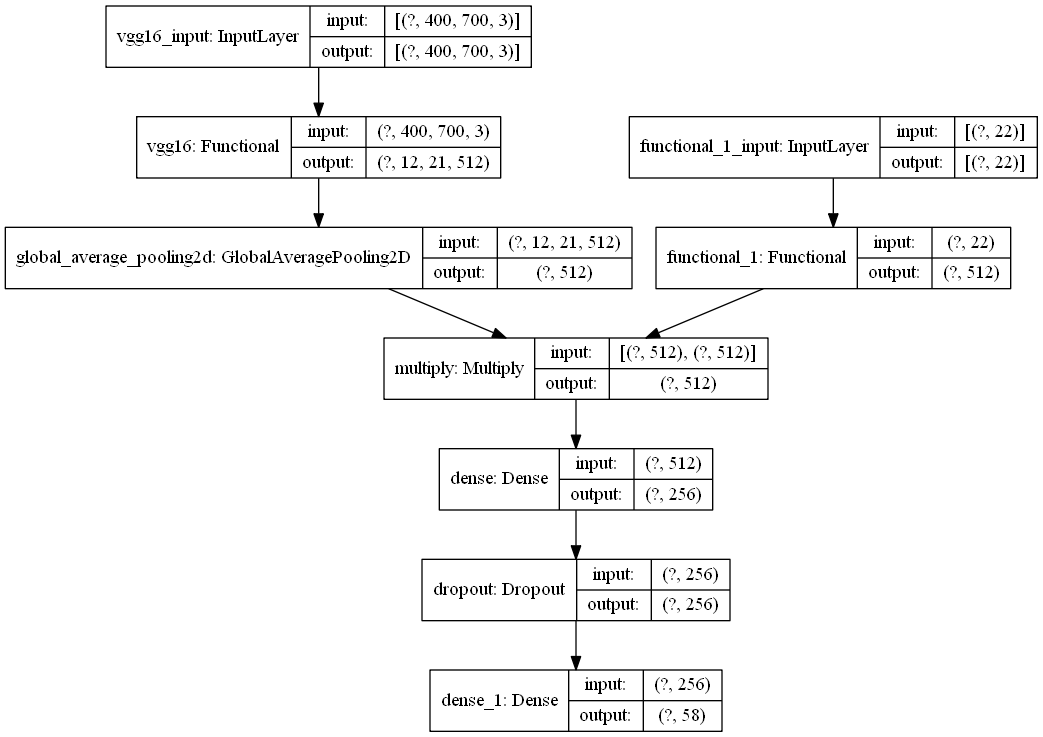

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [28]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.CategoricalCrossentropy() 


# learning rate
lr = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------


# Validation metrics
# ------------------
metrics = ['accuracy']
# ------------------



# Compile Model
model.compile(optimizer=optimizer, loss=loss , metrics=metrics)

In [ ]:
import os
from datetime import datetime

cwd1 = os.getcwd()

exps_dir = os.path.join(cwd1, 'multiclass_exps')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                   save_weights_only=True, save_best_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset)/bs,#+len(dataset1)
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)/bs, #+len(dataset_valid1)
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
2941/2940 [==============================] - 5346s 2s/step - loss: 1.3800 - accuracy: 0.4876 - val_loss: 1.0140 - val_accuracy: 0.5977
Epoch 2/100
2044/2940 [===================>..........] - ETA: 24:44 - loss: 1.0281 - accuracy: 0.5893

In [40]:

from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [41]:
with open(test_QA) as f:
    test_dict = json.load(f)


MAX_NUM_SENTENCES = 70000
MAX_NUM_WORDS = 20000

test_questions = []

# Simplify the dataset
MAX_LEN = 25 # words

# Read all lines in translation dataset
count = 0

for key in test_dict:

#for line in open(os.path.join('/content/drive/My Drive', 'ita.txt'), encoding='utf-8'):
    
    if count > MAX_NUM_SENTENCES:
        break

        
    question = test_dict[key]['question']

    
    if (len(question.split(' ')) > MAX_LEN):
      continue
    
    question = question + ' <eos>'
       
    test_questions.append(question)
    
    count += 1

test_tokenized = ita_tokenizer.texts_to_sequences(test_questions)

# Pad to max italian sentence length
test_encoder_inputs = pad_sequences(test_tokenized, maxlen=max_ita_length)

print("Italian encoder inputs shape:", test_encoder_inputs.shape)

count = 0
for key in test_dict:
    test_dict[key]['question'] = test_encoder_inputs[count]
    count+=1

Italian encoder inputs shape: (6372, 22)


In [43]:
#Prediction computation done one image at time

#model.load_weights(filepath='C:\\Users\\ASUS\\Documents\\Università\\ANNDL\\A2NDLKaggle\\weights\\FC_Nov14_15-02-54\\ckpts\\cp.ckpt')

from PIL import Image
count = 0
results = {}
for key in test_dict:

    # Read Image
    element = test_dict[key]
    image = element['image_id']
    img = Image.open(os.path.join(cwd, 'Images', image + '.png'))
    #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

    img = img.convert('RGB')
    
    # Resize image and mask
    img = img.resize((img_w,img_h))
    img_arr = preprocess_input(np.array(img))
    question = element['question']
    
    pair = {"vgg16_input": img_arr, "zzz_input": question}  
    
    pair['vgg16_input']=tf.expand_dims(pair['vgg16_input'],0)
    pair['zzz_input']=tf.expand_dims(pair['zzz_input'],0)
    
    predictions = np.argmax(model.predict(pair))
    results[key] = predictions
    print (str(count) + ":" +str(predictions))
    count += 1
create_csv(results)


0:49
1:15
2:2
3:33
4:4
5:1
6:1
7:33
8:57
9:57
10:33
11:13
12:1
13:33
14:33
15:33
16:28
17:57
18:33
19:2
20:57
21:51
22:38
23:2
24:3
25:2
26:57
27:6
28:57
29:57
30:2
31:20
32:33
33:1
34:33
35:57
36:2
37:53
38:33
39:4
40:57
41:56
42:2
43:33
44:44
45:33
46:33
47:33
48:33
49:33
50:1
51:57
52:10
53:57
54:33
55:1
56:2
57:1
58:33
59:33
60:11
61:39
62:22
63:33
64:2
65:39
66:2
67:57
68:54
69:57
70:33
71:33
72:57
73:1
74:32
75:33
76:33
77:53
78:14
79:18
80:57
81:3
82:17
83:57
84:2
85:4
86:32
87:39
88:39
89:35
90:33
91:28
92:30
93:39
94:57
95:33
96:2
97:57
98:11
99:37
100:33
101:57
102:34
103:33
104:33
105:33
106:33
107:1
108:57
109:2
110:2
111:33
112:27
113:7
114:33
115:33
116:43
117:11
118:48
119:28
120:57
121:57
122:2
123:33
124:33
125:57
126:25
127:4
128:2
129:57
130:57
131:0
132:2
133:27
134:26
135:2
136:2
137:2
138:33
139:33
140:3
141:57
142:33
143:34
144:57
145:33
146:2
147:2
148:40
149:57
150:57
151:2
152:2
153:6
154:38
155:33
156:5
157:57
158:9
159:2
160:57
161:1
162:39
163:27
164:50
165

1195:17
1196:4
1197:37
1198:57
1199:53
1200:57
1201:2
1202:1
1203:7
1204:57
1205:18
1206:53
1207:33
1208:2
1209:57
1210:26
1211:33
1212:21
1213:41
1214:33
1215:0
1216:2
1217:57
1218:57
1219:2
1220:33
1221:57
1222:57
1223:2
1224:57
1225:33
1226:20
1227:33
1228:57
1229:57
1230:0
1231:39
1232:57
1233:57
1234:33
1235:39
1236:33
1237:4
1238:57
1239:57
1240:2
1241:0
1242:53
1243:57
1244:57
1245:33
1246:2
1247:41
1248:15
1249:57
1250:3
1251:4
1252:16
1253:57
1254:4
1255:57
1256:33
1257:20
1258:27
1259:2
1260:33
1261:2
1262:57
1263:57
1264:33
1265:40
1266:33
1267:57
1268:33
1269:33
1270:57
1271:33
1272:43
1273:33
1274:17
1275:57
1276:57
1277:36
1278:1
1279:31
1280:57
1281:37
1282:2
1283:16
1284:33
1285:2
1286:33
1287:57
1288:2
1289:4
1290:2
1291:18
1292:39
1293:3
1294:13
1295:21
1296:25
1297:57
1298:43
1299:21
1300:39
1301:33
1302:4
1303:1
1304:15
1305:39
1306:57
1307:43
1308:2
1309:44
1310:28
1311:56
1312:54
1313:57
1314:1
1315:57
1316:10
1317:6
1318:18
1319:2
1320:1
1321:33
1322:57
1323:57
1

2248:2
2249:33
2250:57
2251:57
2252:13
2253:33
2254:57
2255:33
2256:33
2257:33
2258:57
2259:39
2260:33
2261:11
2262:51
2263:29
2264:8
2265:57
2266:36
2267:13
2268:33
2269:33
2270:57
2271:33
2272:21
2273:33
2274:2
2275:2
2276:20
2277:33
2278:33
2279:33
2280:53
2281:55
2282:39
2283:10
2284:18
2285:57
2286:2
2287:39
2288:2
2289:34
2290:2
2291:0
2292:1
2293:14
2294:1
2295:1
2296:57
2297:57
2298:39
2299:33
2300:57
2301:13
2302:2
2303:33
2304:53
2305:57
2306:1
2307:2
2308:21
2309:6
2310:20
2311:57
2312:39
2313:2
2314:2
2315:57
2316:57
2317:53
2318:33
2319:57
2320:33
2321:13
2322:33
2323:33
2324:17
2325:57
2326:39
2327:1
2328:49
2329:33
2330:3
2331:2
2332:39
2333:57
2334:42
2335:2
2336:57
2337:33
2338:2
2339:23
2340:27
2341:15
2342:18
2343:33
2344:25
2345:57
2346:33
2347:13
2348:57
2349:57
2350:39
2351:57
2352:13
2353:2
2354:39
2355:57
2356:33
2357:2
2358:33
2359:33
2360:33
2361:2
2362:50
2363:2
2364:35
2365:57
2366:14
2367:2
2368:2
2369:33
2370:4
2371:47
2372:57
2373:33
2374:2
2375:57
2376:3

3300:33
3301:2
3302:33
3303:57
3304:57
3305:33
3306:0
3307:33
3308:57
3309:18
3310:33
3311:33
3312:57
3313:33
3314:33
3315:2
3316:2
3317:4
3318:20
3319:39
3320:43
3321:57
3322:2
3323:57
3324:33
3325:30
3326:57
3327:57
3328:0
3329:33
3330:1
3331:19
3332:56
3333:40
3334:33
3335:1
3336:33
3337:57
3338:57
3339:57
3340:1
3341:33
3342:33
3343:33
3344:3
3345:33
3346:0
3347:4
3348:33
3349:33
3350:41
3351:35
3352:1
3353:53
3354:57
3355:33
3356:2
3357:11
3358:1
3359:33
3360:33
3361:2
3362:31
3363:33
3364:33
3365:33
3366:50
3367:40
3368:57
3369:57
3370:57
3371:33
3372:2
3373:33
3374:33
3375:49
3376:57
3377:21
3378:33
3379:53
3380:33
3381:33
3382:33
3383:33
3384:39
3385:57
3386:2
3387:57
3388:57
3389:33
3390:57
3391:57
3392:33
3393:9
3394:33
3395:33
3396:4
3397:57
3398:33
3399:50
3400:57
3401:20
3402:32
3403:57
3404:11
3405:33
3406:44
3407:33
3408:56
3409:33
3410:33
3411:57
3412:57
3413:33
3414:27
3415:1
3416:57
3417:57
3418:33
3419:2
3420:57
3421:20
3422:2
3423:57
3424:2
3425:57
3426:2
3427:13
34

4356:32
4357:57
4358:2
4359:1
4360:33
4361:33
4362:13
4363:14
4364:3
4365:57
4366:56
4367:2
4368:57
4369:33
4370:33
4371:33
4372:33
4373:57
4374:57
4375:39
4376:57
4377:39
4378:0
4379:33
4380:2
4381:57
4382:3
4383:2
4384:15
4385:57
4386:19
4387:2
4388:33
4389:33
4390:13
4391:57
4392:39
4393:33
4394:33
4395:57
4396:57
4397:33
4398:31
4399:2
4400:57
4401:39
4402:57
4403:2
4404:57
4405:39
4406:57
4407:48
4408:57
4409:57
4410:15
4411:2
4412:57
4413:33
4414:4
4415:2
4416:33
4417:57
4418:33
4419:9
4420:33
4421:57
4422:33
4423:33
4424:33
4425:18
4426:33
4427:33
4428:33
4429:57
4430:33
4431:34
4432:2
4433:37
4434:33
4435:39
4436:21
4437:56
4438:1
4439:57
4440:1
4441:21
4442:33
4443:2
4444:33
4445:1
4446:43
4447:37
4448:33
4449:57
4450:15
4451:57
4452:33
4453:57
4454:33
4455:57
4456:20
4457:57
4458:11
4459:20
4460:2
4461:2
4462:23
4463:35
4464:2
4465:20
4466:51
4467:2
4468:57
4469:46
4470:56
4471:57
4472:52
4473:57
4474:42
4475:29
4476:33
4477:53
4478:57
4479:33
4480:2
4481:33
4482:56
4483:33
4

5409:26
5410:33
5411:33
5412:20
5413:33
5414:33
5415:43
5416:2
5417:57
5418:33
5419:57
5420:33
5421:57
5422:53
5423:57
5424:57
5425:33
5426:57
5427:33
5428:57
5429:1
5430:56
5431:57
5432:57
5433:6
5434:33
5435:39
5436:53
5437:2
5438:57
5439:57
5440:2
5441:41
5442:37
5443:33
5444:33
5445:35
5446:33
5447:39
5448:2
5449:33
5450:57
5451:57
5452:2
5453:57
5454:57
5455:33
5456:2
5457:57
5458:53
5459:39
5460:12
5461:18
5462:56
5463:57
5464:33
5465:18
5466:37
5467:22
5468:33
5469:36
5470:33
5471:33
5472:2
5473:48
5474:2
5475:3
5476:38
5477:19
5478:56
5479:6
5480:34
5481:21
5482:57
5483:33
5484:17
5485:4
5486:2
5487:33
5488:57
5489:2
5490:57
5491:33
5492:35
5493:35
5494:57
5495:30
5496:2
5497:33
5498:33
5499:57
5500:33
5501:55
5502:57
5503:1
5504:33
5505:2
5506:12
5507:57
5508:39
5509:33
5510:33
5511:33
5512:3
5513:28
5514:57
5515:40
5516:57
5517:33
5518:20
5519:57
5520:57
5521:10
5522:46
5523:33
5524:33
5525:1
5526:53
5527:57
5528:2
5529:33
5530:46
5531:0
5532:33
5533:25
5534:22
5535:2
5536:33

In [32]:
train_dataset.element_spec

({'vgg16_input': TensorSpec(shape=(None, 400, 700, 3), dtype=tf.float32, name=None),
  'model_input': TensorSpec(shape=(None, 22), dtype=tf.float32, name=None)},
 TensorSpec(shape=(None, 58), dtype=tf.float32, name=None))

In [ ]:
model.inputs

In [58]:
model.save_weights(os.path.join(os.getcwd(),'multiclass_exps/Manual/ckpts/cp.ckpt'))


In [32]:
train_dataset

<RepeatDataset shapes: ({input_1: (None, 400, 700, 3), input_2: (None, 22)}, (None, 58)), types: ({input_1: tf.float32, input_2: tf.float32}, tf.float32)>

AttributeError: 'dict' object has no attribute 'shape'